In [1]:
import sys
import os, os.path

sys.path.append(os.path.join(os.getcwd() ,'/modules'))
root_path = "C:/git/Springboard-Public/Capstone Project 2/"
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    root_path = "/content/drive/My Drive/Capstone Project 2/"

print('Current Working Dir: ', os.getcwd())
print('Root Path: ', root_path)

# We need to set the working directory since we are using relative paths from various locations
if os.getcwd() != root_path:
  os.chdir(root_path)

Current Working Dir:  C:\git\Springboard-Public\Capstone Project 2\notebooks\Support Notebooks for Modules
Root Path:  C:/git/Springboard-Public/Capstone Project 2/


In [2]:
import numpy as np
from sklearn import metrics
from datetime import datetime
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from modules.lib.CheXpertData import *
from modules.lib.Metrics import *
from modules.lib.TrainingLoop import *
from modules.models.CustomPneumonia import CustomPneumoniaNN

from PIL import Image
import copy

import torch.optim as optim
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor, ToPILImage
import torchvision.models as models

from torchsummary import summary

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

%matplotlib inline

In [3]:
force_cpu = True
device = torch.device('cuda' if ~force_cpu and torch.cuda.is_available() else 'cpu')
# Assume that we are on a CUDA machine, then this should print a CUDA device:
print(f'Working on device={device}')

Working on device=cuda


In [4]:
loaders = Loaders()
batch_size=16
val_percent=0.15
number_images = 20000
train_loader, val_loader = loaders.getDataTrainValidateLoaders(batch_size=batch_size, 
                                                                        val_percent=val_percent, 
                                                                        n_random_rows=number_images)

target_columns = loaders.target_columns

train_actual = loaders.train_df
val_actual = loaders.val_df

print(f'Number of Training Batches: {len(train_loader):,}')
print(f'Number of Validation Batches: {len(val_loader):,}')
print(f'Number of Training Images: {len(train_loader) * batch_size:,}')
print(f'Number of Validation Images: {len(val_loader) * batch_size:,}')

Number of Training Batches: 1,065
Number of Validation Batches: 186
Number of Training Images: 17,040
Number of Validation Images: 2,976


In [5]:
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.softmax = nn.Softmax(dim=1)       
        self.flattened_length_ = 1*320*320
        self.fc1 = nn.Linear(self.flattened_length_, 12)
       
    def forward(self, x):    
        x = x.view(-1, self.flattened_length_)    
        x = self.fc1(x)
        return x

In [6]:
net = SimpleModel()

net = nn.DataParallel(net)
net.to(device)

summary(net, (1, 320, 320)) #Known Harded code size generated by data loaders (todo: make attribute of loaders)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 12]       1,228,812
       SimpleModel-2                   [-1, 12]               0
Total params: 1,228,812
Trainable params: 1,228,812
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.39
Forward/backward pass size (MB): 0.00
Params size (MB): 4.69
Estimated Total Size (MB): 5.08
----------------------------------------------------------------


In [7]:
learning_rate = 1e-4
num_epochs = 2

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)#, weight_decay=0.9)

metrics = Metrics(target_columns, train_actual, val_actual, cc=0)
trainingLoop = TrainingLoop(device, net, optimizer, criterion, metrics)

In [8]:
help(Metrics.displayMetrics)

Help on function displayMetrics in module modules.lib.Metrics:

displayMetrics(self, metricDataSource=<MetricDataSource.Both: 0>, showCombinedMetrics=True, showMetricDataFrame=True, showROCCurves=True, showPrecisionRecallCurves=True, include_targets=None, combinedAverageMethod='samples', gridSpecColumnCount=4, gridSpecHeight=3, gridSpecWidth=20)
    docstring



In [9]:
trainingLoop.epoch_metric_display_args = (0, True, False, False, False,  ['Edema', 'Lung_Opacity', 'Pneumonia'])

In [10]:
trainingLoop.train(num_epochs, train_loader, val_loader)

▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
Epoch [1/2]
▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔
▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔
Epoch Loss: 778.6326         
Time of Completion: 2020-07-30 17:01:47.695418          
Training Duration: 0:01:21.588759          
Validation Duration: 0:00:12.369877

TRAINING

▔▔▔▔▔


,Score for all Targets
Accuracy Score,0.089853
Hamming Loss,0.179417
Combined Recall,0.243438
Combined Precision,0.264641
Combined F1,0.228817



VALIDATION

▔▔▔▔▔▔▔


,Score for all Targets
Accuracy Score,0.131375
Hamming Loss,0.167286
Combined Recall,0.302173
Combined Precision,0.307787
Combined F1,0.275859


▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
Epoch [2/2]
▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔
▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔
Epoch Loss: 753.8781         
Time of Completion: 2020-07-30 17:03:32.889996          
Training Duration: 0:01:23.679115          
Validation Duration: 0:00:21.415707

TRAINING

▔▔▔▔▔


,Score for all Targets
Accuracy Score,0.094900
Hamming Loss,0.175069
Combined Recall,0.254614
Combined Precision,0.273979
Combined F1,0.238910



VALIDATION

▔▔▔▔▔▔▔


,Score for all Targets
Accuracy Score,0.118541
Hamming Loss,0.173562
Combined Recall,0.160402
Combined Precision,0.207188
Combined F1,0.165964



TRAINING

▔▔▔▔▔


,Score for all Targets
Accuracy Score,0.094900
Hamming Loss,0.175069
Combined Recall,0.254614
Combined Precision,0.273979
Combined F1,0.238910


,Target,True Positive Count,Recall,Precision,F1,ROC AUC,Avg Precision
0,Enlarged_Cardiomediastinum,909,0.069307,0.085135,0.076410,0.544139,0.064399
1,Cardiomegaly,1910,0.162827,0.187124,0.174132,0.593926,0.157671
2,Lung_Opacity,7802,0.506537,0.510001,0.508263,0.567971,0.511652
3,Lung_Lesion,728,0.049451,0.056515,0.052747,0.565050,0.052898
4,Edema,4068,0.320551,0.347548,0.333504,0.622638,0.326460
5,Consolidation,1014,0.064103,0.076291,0.069668,0.545192,0.069283
6,Pneumonia,473,0.046512,0.048458,0.047465,0.553502,0.035234
7,Atelectasis,2720,0.161765,0.188598,0.174154,0.532265,0.173596
8,Pneumothorax,1371,0.093363,0.114695,0.102935,0.564152,0.101796
9,Pleural_Effusion,5854,0.435600,0.454060,0.444638,0.621421,0.442904


***** ROC *****


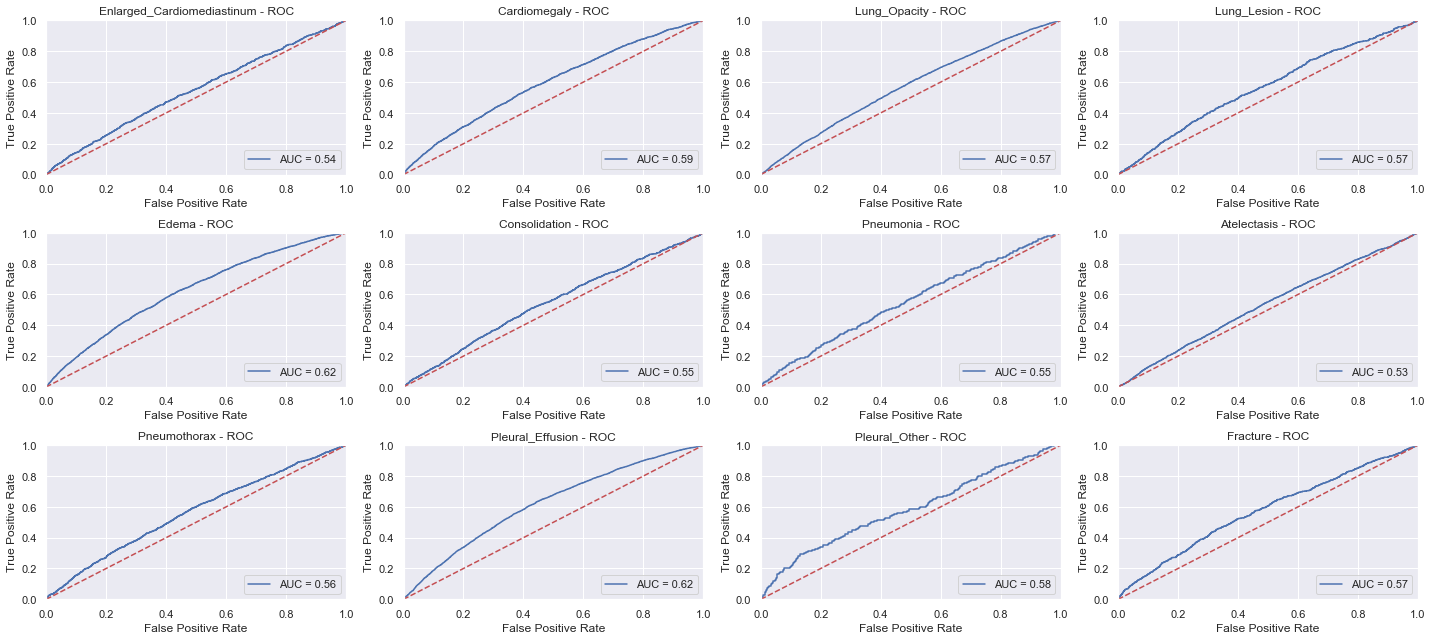

***** Precision / Recall *****


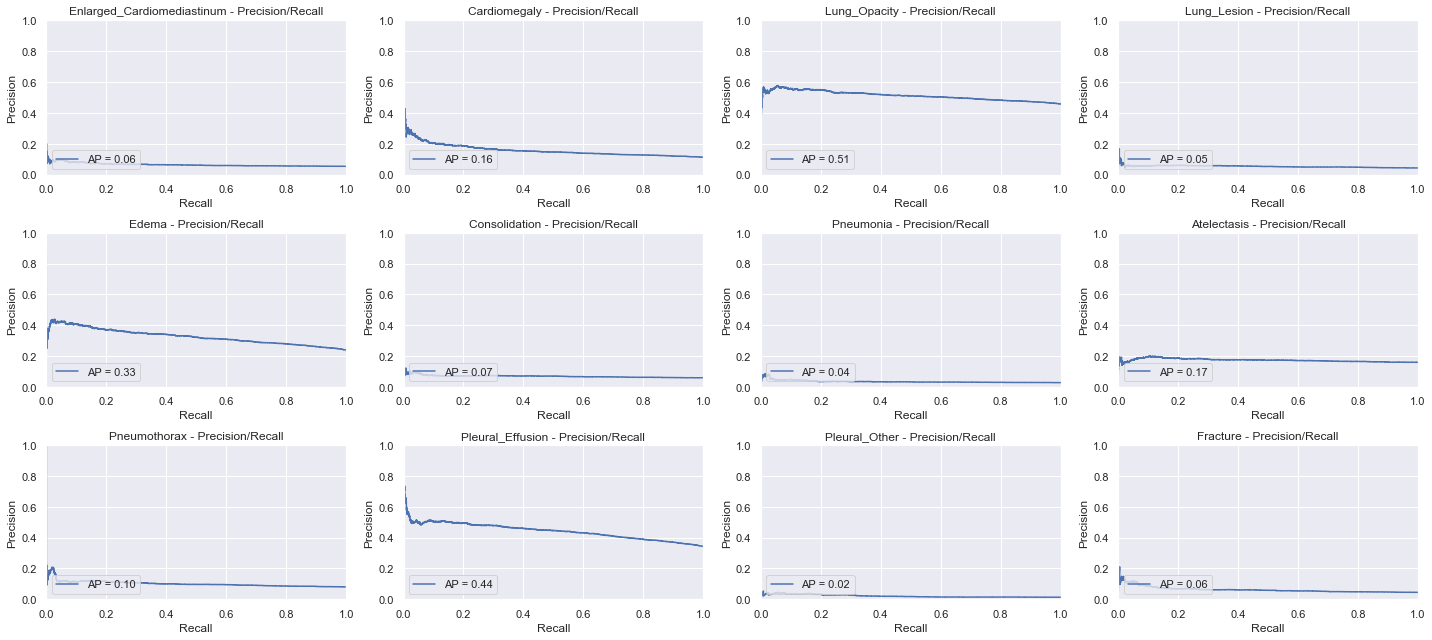


VALIDATION

▔▔▔▔▔▔▔


,Score for all Targets
Accuracy Score,0.118541
Hamming Loss,0.173562
Combined Recall,0.160402
Combined Precision,0.207188
Combined F1,0.165964


,Target,True Positive Count,Recall,Precision,F1,ROC AUC,Avg Precision
0,Enlarged_Cardiomediastinum,123,0.016260,0.200000,0.030075,0.524625,0.055233
1,Cardiomegaly,325,0.092308,0.202703,0.126850,0.631967,0.166898
2,Lung_Opacity,1354,0.302806,0.489845,0.374258,0.535623,0.480384
3,Lung_Lesion,117,0.017094,0.080000,0.028169,0.511627,0.044258
4,Edema,687,0.564774,0.311897,0.401864,0.636115,0.336275
5,Consolidation,161,0.149068,0.062827,0.088398,0.534918,0.058550
6,Pneumonia,75,0.040000,0.020979,0.027523,0.506316,0.030541
7,Atelectasis,473,0.215645,0.178634,0.195402,0.514588,0.171341
8,Pneumothorax,233,0.012876,0.107143,0.022989,0.527494,0.086317
9,Pleural_Effusion,971,0.017508,0.361702,0.033399,0.583168,0.382652


***** ROC *****


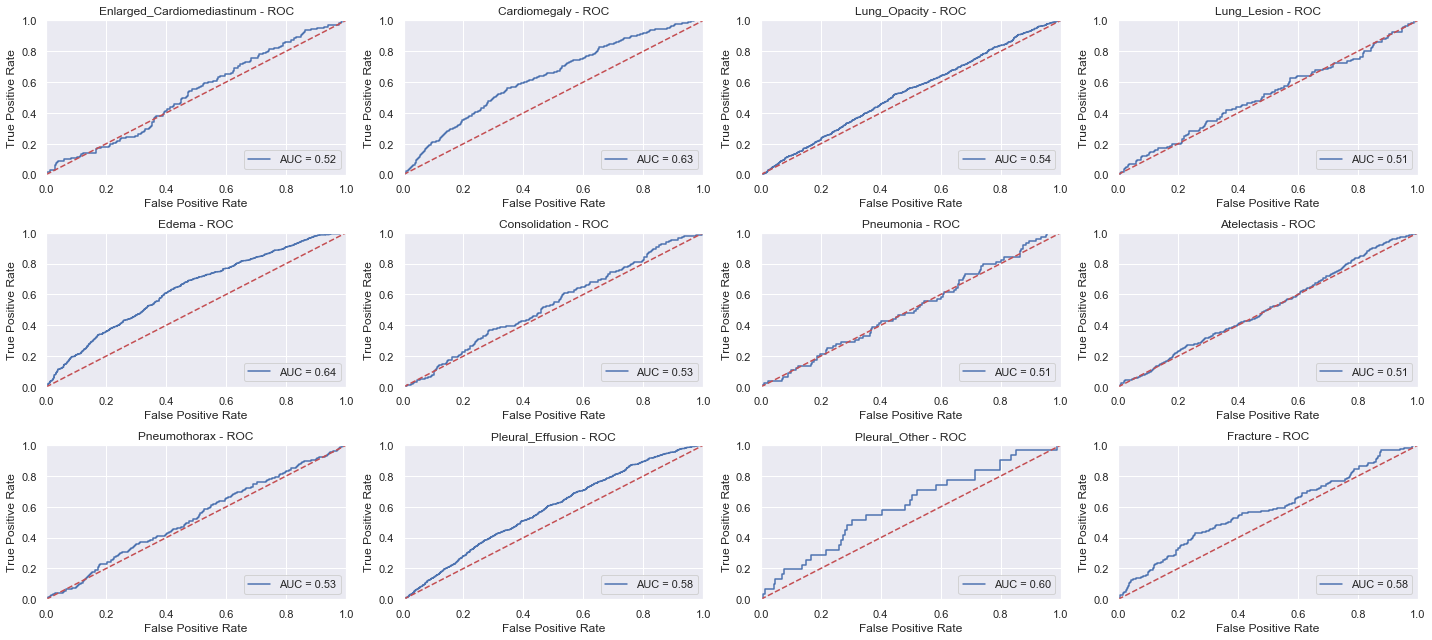

***** Precision / Recall *****


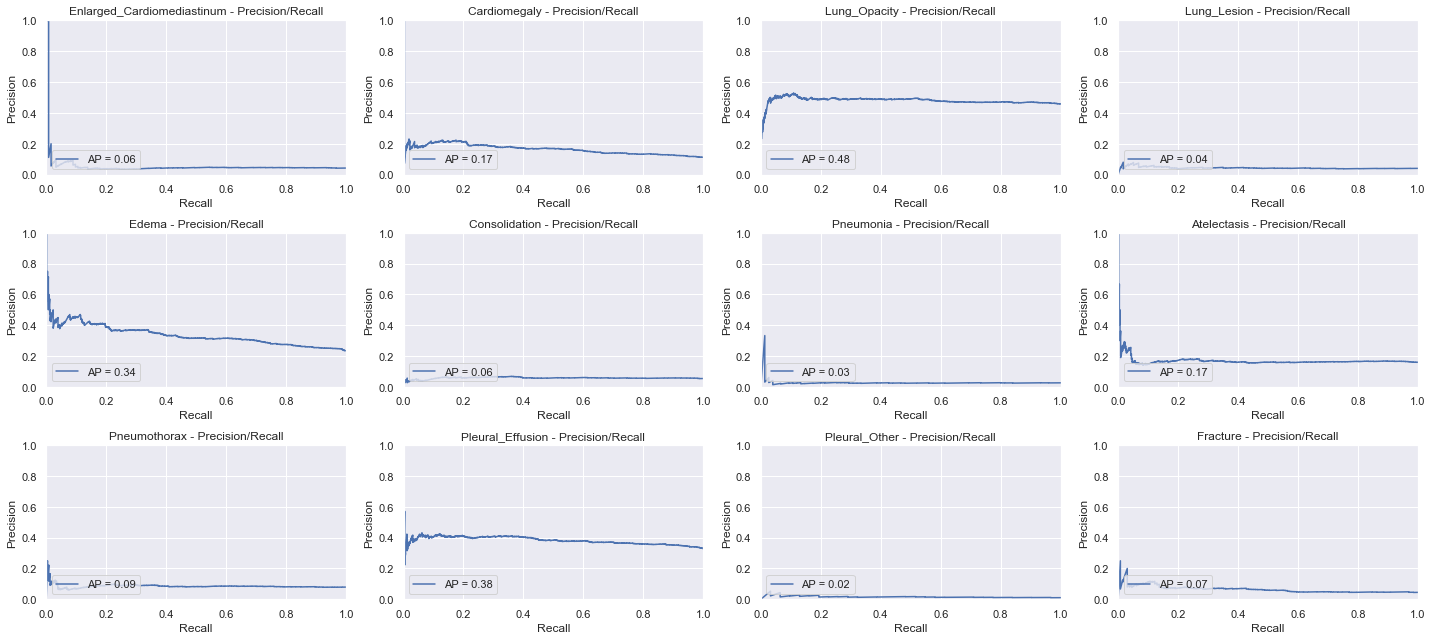

In [11]:
metrics.displayMetrics()

## Results

Since the model was not expected to do better than a 50/50 chance, the final metric output looks good.

One of the best indicators of the 50/50 model is the ROC curves.  For training, all the curves are on the diagonal.

Also, the P/R curves do not look like P/R curves.  In fact, the Average Precision approximates the ground truth positive percentages.